In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from contextlib import contextmanager

from rnndatasets import sequentialmnist as mnist

from itertools import chain

Can we make a network that starts small and grows by splitting its layers?

In [2]:
@contextmanager
def new_collection(name):
    old_tvars = tf.trainable_variables()
    yield
    for var in tf.trainable_variables():
        if var not in old_tvars:
            tf.add_to_collection(name, var)

In [3]:
def affine(input_var, new_size, weights_initialiser=None, bias_initialiser=None, return_weights=False):
    input_size = input_var.get_shape()[1].value
    
    if type(weights_initialiser) == np.ndarray:
        weight_shape = None
    else:
        weight_shape = [input_size, new_size]
    
    if type(bias_initialiser) == np.ndarray:
        bias_shape = None
    else:
        bias_shape = [new_size]
    
    weights = tf.get_variable('weights', weight_shape,
                             initializer=weights_initialiser)
    bias = tf.get_variable('bias', bias_shape,
                           initializer=bias_initialiser)
    results = tf.nn.bias_add(tf.matmul(input_var, weights), bias)
    
    if return_weights:
        return results, (weights, bias)
    return results

In [4]:
def initial_net(input_var, output_shape):
    return affine(input_var, output_shape)

In [5]:
def batch_iter(data, labels, batch_size):
    num_batches = data.shape[0] // batch_size
    
    for i in range(num_batches):
        yield data[i*batch_size:(i+1)*batch_size, ...], labels[i*batch_size:(i+1)*batch_size]

In [6]:
def lennox(activations, sess=None):
    num_features = activations.get_shape()[1].value
    a = tf.get_variable('a', [num_features], initializer=tf.constant_initializer(1.0))
    b = tf.get_variable('b', [num_features], initializer=tf.constant_initializer(1.0))
    c = tf.get_variable('c', [num_features], initializer=tf.constant_initializer(0.0))
    
    centered = activations - c
    
    return tf.select(centered > 0, a * centered, b * centered)

In [7]:
def get_metrics(net, targets):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(net, targets)
    loss = tf.reduce_mean(loss)
    acc = tf.contrib.metrics.accuracy(tf.cast(tf.argmax(net_out, 1), tf.int32),
                                      targets)
    return loss, acc

def split(session, split_layer, output_layer, layer_in, targets, scope):
    # figure out the new value in numpy to keep the graph clean
    weights_var, bias_var = split_layer
    weights_val, bias_val = session.run([weights_var, bias_var])
    u, s, vT = np.linalg.svd(weights_val, full_matrices=False)
    
    with tf.variable_scope('model'):
        with new_collection('weights'):
            with tf.variable_scope(scope + '_split_1'):
                split_in, hh_vars = affine(layer_in, len(s), weights_initialiser=np.dot(u, np.diag(s)), bias_initialiser=bias_val,
                                                 return_weights=True)
            with tf.variable_scope(scope + '_split_2'):
                split_out, split_vars = affine(lennox(split_in), len(s), weights_initialiser=vT,
                                             bias_initialiser=tf.constant_initializer(0.0), return_weights=True)
        with tf.variable_scope('output', reuse=True):
            net_out = affine(lennox(split_out), 10)
        
    loss, acc = get_metrics(net_out, targets)
    
    opt = tf.train.AdamOptimizer(0.001)
    train_op = opt.minimize(loss)
    
    return train_op, split_vars, loss, acc, split_in
    

In [10]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, 784])
targets = tf.placeholder(tf.int32, [None])


with tf.variable_scope('model'):
    with new_collection('weights'):
        net_out, split_layer = affine(inputs, 5, return_weights=True)
        split_in = inputs
        with tf.variable_scope('output'):
            net_out, output_layer = affine(lennox(net_out), 10, return_weights=True)

loss, acc = get_metrics(net_out, targets)

opt = tf.train.AdamOptimizer(0.001)
train_op = opt.minimize(loss, var_list=tf.get_collection('weights'))

In [11]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

losses = []
valid_losses = []

num_splits = 0
valid_loss = 0
split_every = 5

for epoch in range(500):
    train, valid, test = mnist.get_iters(batch_size=64, shuffle=True)
    
    epoch_loss = 0
    epoch_steps = 0
    for dbatch, tbatch in train:
        dbatch = dbatch.transpose((1, 0, 2))
        batch_loss, _ = sess.run([loss, train_op],
                                 {inputs: dbatch.reshape((-1, 784)),
                                  targets: tbatch})
        epoch_loss += batch_loss
        epoch_steps += 1
        
    if (epoch % 5) == 1:
        valid_loss = 0
        valid_steps = 0
        for dbatch, tbatch in valid:
            dbatch = dbatch.transpose((1, 0, 2))
            batch_loss = sess.run(acc,
                                 {inputs: dbatch.reshape((-1, 784)),
                                  targets: tbatch})
            valid_loss += batch_loss
            valid_steps += 1
        valid_loss /= valid_steps
        valid_losses.append(valid_loss)
    
    
    print('\r({}) ~~ {}  (valid: {})'.format(epoch, epoch_loss/epoch_steps, valid_loss), end='')
    losses.append(epoch_loss/epoch_steps)
    
    if (epoch % split_every) == 0:
        split_every *= 2
        valid_loss = 100
        print('\ntime to split')
        num_splits += 1
        train_op, split_layer, loss, acc, split_in = split(
            sess, split_layer, output_layer, split_in, targets, 'split_{}'.format(num_splits))
        num_splits += 1
        uninits = [var for var in tf.all_variables() if not sess.run(tf.is_variable_initialized(var))]
        sess.run([var.initializer for var in uninits])

(0) ~~ 1.0487745669449795  (valid: 0)
time to split
(10) ~~ 0.40226175816355225  (valid: 0.7342748397435898)
time to split
(20) ~~ 0.3796907064532348  (valid: 0.5894431089743589)
time to split
(40) ~~ 0.361360213200582  (valid: 0.45262419871794873)
time to split
(80) ~~ 0.34535199890292406  (valid: 0.34485176282051283)
time to split
(160) ~~ 0.3173078372406746  (valid: 0.23297275641025642)
time to split
(320) ~~ 0.3010212542648963  (valid: 0.17878605769230768)
time to split
(499) ~~ 0.29460649229538427  (valid: 0.18609775641025642)

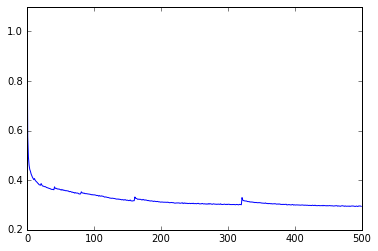

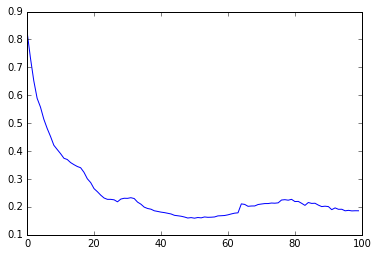

In [12]:
plt.plot(losses)
plt.show()
plt.plot(np.arange(len(valid_losses)) * 1, valid_losses)
plt.show()